### Klasyfikacja binarna oparta na konwolucyjnych sieciach neuronowych (CNN)

Jeśli komórki są zakażone mykoplazmą to uzyskane prawdopodobieństwo jest bliskie 1, jeśli komórki są zakażone mykoplazmą to uzyskane prawdopodobieństwo jest bliskie  0.

Label dla komórek zakażonych : 1, label dla komórek zdrowych : 0.

### Biblioteki i Pakiety

In [54]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical, normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Wczytywanie Katalogów ze Zdjęciami

In [55]:
# ścieżki do katalogów z obrazami komórek z mykoplazmą (positive) i bez mykoplazmy (negative) - do zmiany w zależności od miejsca w którym znajdują się wprowadzane miejsca
positive_directory = r"C:\Users\IgA\Documents\Machine_learning_Chemia\mycoplasma\all\positive" 
negative_directory = r"C:\Users\IgA\Documents\Machine_learning_Chemia\mycoplasma\all\negative"

# sprawdzanie czy ścieżki do folderów są prawidłowe i jakie pliki się w nich znajdują
def check_directory(directory, name):
    if not os.path.exists(directory):
        print(f"Ścieżka do folderu {name} NIE jest prawidłowa")
    else:
        print(f"Ścieżka do folderu {name} JEST PRAWIDŁOWA")
        print('----------------------------------------------')
        print(f"Pliki w katalogu '{name}':")
        print(os.listdir(directory))  # Wyświetlenie zawartości katalogu

# printowanie wyników
check_directory(positive_directory, "positive")
print()
print()
check_directory(negative_directory, "negative")

Ścieżka do folderu positive JEST PRAWIDŁOWA
----------------------------------------------
Pliki w katalogu 'positive':
['mycoplasma_positive_1.jpg', 'mycoplasma_positive_1_90.jpg', 'mycoplasma_positive_1_reversed.jpg', 'mycoplasma_positive_2.jpg', 'mycoplasma_positive_2_90.jpg', 'mycoplasma_positive_2_reversed.jpg', 'mycoplasma_positive_3.jpg', 'mycoplasma_positive_3_90.jpg', 'mycoplasma_positive_3_reversed.jpg', 'mycoplasma_positive_4.jpg', 'mycoplasma_positive_4_90.jpg', 'mycoplasma_positive_4_reversed.jpg', 'mycoplasma_positive_5.jpg', 'mycoplasma_positive_5_90.jpg', 'mycoplasma_positive_5_reversed.jpg', 'mycoplasma_positive_6.jpg', 'mycoplasma_positive_6_90.jpg', 'mycoplasma_positive_6_reversed.jpg', 'positive_labels.json']


Ścieżka do folderu negative JEST PRAWIDŁOWA
----------------------------------------------
Pliki w katalogu 'negative':
['mycoplasma_negative_1.jpg', 'mycoplasma_negative_1_90.jpg', 'mycoplasma_negative_1_reversed.jpg', 'mycoplasma_negative_2.jpg', 'mycoplasm

### Docelowe Wymiary Obrazów i Utworzenie List

In [56]:
# wymiary do których obrazy zostaną przekształcone (wszystkie muszą mieć takie same wymiary a tu mają inne)
width = 400
height = 300

# listy do przechowywania kolejno obrazów i etykiet
images = []
labels = []

### Zmiana Rozmiarów Obrazów i Dodanie Etykiet

In [57]:
# określenie w którym katalogu znajdują się komórki zakażone mykoplazmą a w którym zdrowe
mycoplasma_positive = os.listdir(positive_directory)
mycoplasma_negative = os.listdir(negative_directory)

# przypisanie klas zdjęciom (1 - komórki zakażone, 0 - komórki zdrowe) i ich przekształcenie
for directory, class_label in [(positive_directory, 1), (negative_directory, 0)]:
    image_names = os.listdir(directory)
    for image_name in image_names:
        if image_name.endswith('.jpg'):
            image_path = os.path.join(directory, image_name)
            image = cv2.imread(image_path)
            image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 'RGB')
            image_size = image.resize((width, height))
            images.append(np.array(image_size))
            labels.append(class_label)

In [58]:
# konwersja list na tablice NumPy
dataset = np.array(images)
labels = np.array(labels)

# sprawdzenie ile mamy obrazów i czy przypisane zostały im labele
print("Number of images in dataset:", len(dataset))
print("Number of labels in dataset:", len(labels))  

Number of images in dataset: 36
Number of labels in dataset: 36


In [59]:
# podział danych na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size = 0.20, random_state = 42)

# normalizacja danych wzdłuż wierszy
X_train = normalize(X_train, axis=1)
X_test = normalize(X_test, axis=1)

In [60]:
# przygotowanie konwolucyjnej sieci neuronowej (CNN) z użyciem Keras

# określenie wymiarów wejściowych obrazów (zdefiniowane wcześniej)
input_shapes = (width, height, 3)

# pierwsza warstwa wejściowa
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = input_shapes))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

# druga warstwa wejściowa
model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

# trzecia warstwa wejściowa
model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.5))

# uśrednianie w ramach kanałów
model.add(GlobalAveragePooling2D())

# warstwa gęsta
model.add(Dense(64))
model.add(Activation('relu'))

# regularyzacja by zapobiec przeuczeniu modelu (tu wybrane 50%)
model.add(Dropout(0.5))

# warstwa wyjściowa - funkcja sigmoidalna sprawia że wyniki znajdują się w zakresie (0, 1)
model.add(Dense(1))
model.add(Activation('sigmoid'))

# kompilacja modelu
model.compile(loss = 'binary_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

print(model.summary())

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 398, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_33 (Activation)      │ (None, 398, 298, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 199, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 199, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 197, 147, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_34 (Activation)      │ (None, 197, 147, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 98, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 98, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 96, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_35 (Activation)      │ (None, 96, 71, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 48, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 48, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_36 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_37 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,865 (128.38 KB)

 Trainable params: 32,865 (128.38 KB)

 Non-trainable params: 0 (0.00 B)

None


In [64]:
# trenowanie modelu na danych treningowych
history = model.fit(
    X_train,
    y_train,
    batch_size = 10,
    verbose = 1, #2 dla bardziej szczegółowych informacji, 0 dla braku
    epochs = 40,
    validation_data = (X_test, y_test),
    shuffle = False,         
    )

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step - accuracy: 0.7500 - loss: 0.4854 - val_accuracy: 0.7500 - val_loss: 0.4439
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step - accuracy: 0.7250 - loss: 0.5100 - val_accuracy: 0.7500 - val_loss: 0.4371
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.7500 - loss: 0.4817 - val_accuracy: 0.7500 - val_loss: 0.4499
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7554 - loss: 0.5446 - val_accuracy: 0.7500 - val_loss: 0.4396
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.6946 - loss: 0.4946 - val_accuracy: 0.7500 - val_loss: 0.4407
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.6089 - loss: 0.5640 - val_accuracy: 0.7500 - val_loss: 0.4506
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.7500 - loss: 0.4615 - val_accuracy: 0.7500 - val_loss: 0.4463
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.7250 - loss: 0.5229 - val_accuracy: 0.7500 - val_loss:

In [65]:
# zapisanie wyuczonego modelu
model.save('mycoplasma_model.h5')

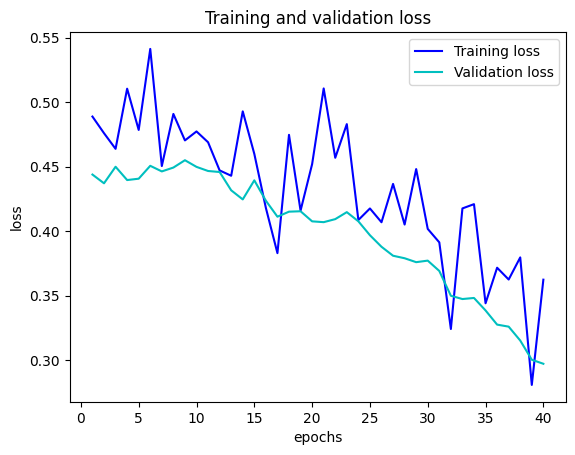

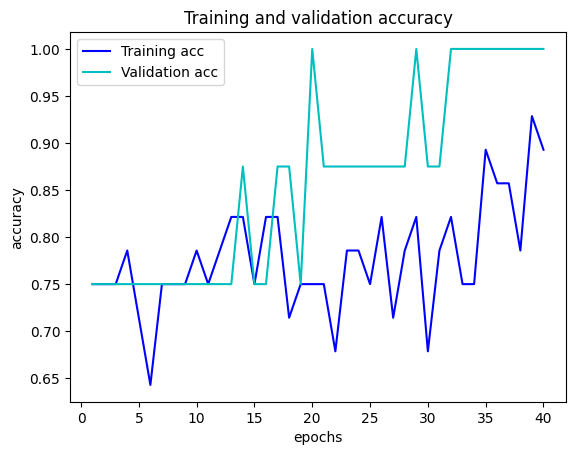

In [66]:
# określenie straty podczas uczenia modelu - określenie jak dobrze model dopasowuje się do danych treningowych
loss = history.history['loss']

# określenie straty na danych walidacyjnych - jak model działa na danych walidacyjnych których nie widział w czasie treningu
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# wykres : training and validation loss
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'c', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# dokładności obliczone dla danych treningowych a następnie walidacyjnych
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# wykres : training and validation accuracy
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'c', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.2972
accuracy:  100.0 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Prediction:  [[0.0381711]]
Real label:  0


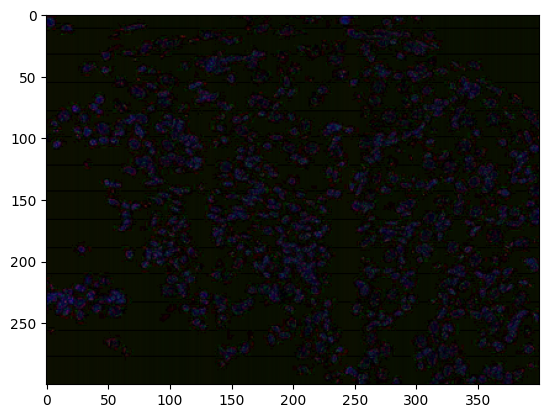

In [77]:
# dokładność (accuracy) wytrenowanego modelu
_, acc = model.evaluate(X_test, y_test)
print('accuracy: ', (acc * 100.0), '%')

# wyświetlenie wybranego obrazu ze zbioru testowego - by zobaczyć inny obraz zmień wartość n
n=2
img = X_test[n]
plt.imshow(img)

# użycie modelu do sprawdzenia klasy obrazu i porównanie jej z rzeczywistą klasą
input_img = np.expand_dims(img, axis = 0)
print('Prediction: ', model.predict(input_img))
print('Real label: ', y_test[n])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.2972
accuracy:  100.0 %


### Confusion Matrix

In [88]:
# ustalenie thresholdu - progu klasyfikacji 
mythreshold = 0.48

In [89]:
# obliczenie macierzy pomyłek z wybranych thresholdem
y_pred = (model.predict(X_test) >= mythreshold).astype(int)
cm = confusion_matrix(y_test, y_pred)
print(cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[5 0]
 [0 3]]


### ROC Curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


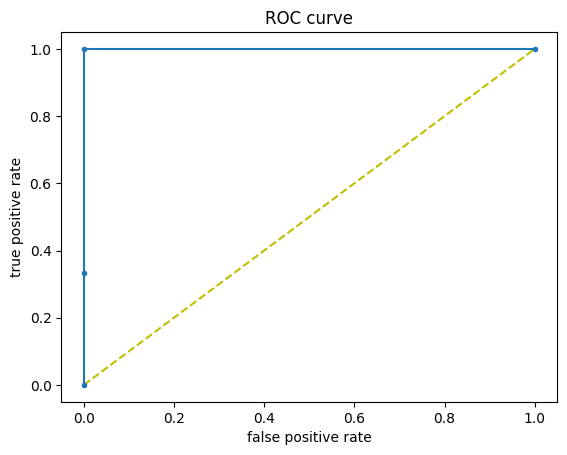

Area under curve, AUC =  1.0


In [71]:
# obliczenie i zwizualizowanie krzywej ROC
y_preds = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker = '.')
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

# obliczenie wartości AUC
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)